In [19]:
# GFM-IAIF
# Glottal Flow Model-based Iterative Adaptive Inverse Filtering
#
# Description
#   This function estimates the linear prediction coefficients of both
#   vocal tract and glottis filters from a speech signal frame with the
#   GFM-IAIF method [1].
#   The latter is an extension of IAIF [2], with an improved pre-emphasis
#   step, that allows to extract a wide-band glottis response,
#   incorporating both glottal formant and spectral tilt characteristics.
#   This function is based on the iaif.m implementation from the COVAREP
#   toolbox [3].
#
#
# Inputs
# s_gvl :  [Nx1]	Speech signal frame
# (nv)	:  [1x1]	Order of LP analysis for vocal tract (def. 48)
# (ng)	:  [1x1]	Order of LP analysis for glottal source (def. 3)
# (d)  	:  [1x1]	Leaky integration coefficient (def. 0.99)
# (win)	:  [Nx1]	Window used before LPC (def. Hanning)
#
# Outputs
#  av  	:  [1xnv]	LP coefficients of vocal tract contribution
#  ag 	:  [1xng]	LP coefficients of glottis contribution
#  al 	:  [1x2]	LP coefficients of lip radiation contribution
#
#
# Examples
#  [av,ag,al] = gfmiaif(x) provides the LP coefficients of vocal tract,
#               glottis and lip radiation with default parameters
#  [av,ag,al] = gfmiaif(x,nv,ng,d,win) allows to choose parameters
#
# GFM-IAIF has been designed on the assumption that a third order filter
# allows to describe most of the glottis-related timbre variations (e.g.,
# tenseness, effort) with a compact set of parameters.
# Thus, the use of ng = 3 is highly encouraged.
#
#
# References
#  [1] O. Perrotin and I. V. McLoughlin (2019)
#      "A spectral glottal flow model for source-filter separation of
#      speech", in IEEE International Conference on Acoustics, Speech, and
#      Signal Processing (ICASSP), Brighton, UK, May 12-17, pp. 7160-7164.
#
#  [2] P. Alku (1992)
#      "Glottal wave analysis with pitch synchronous iterative adaptive
#      inverse filtering", Speech Communication, 11(2-3), pp. 109-118.
#
#  [3] G. Degottex, J. Kane, T. Drugman, T. Raitio and S. Scherer (2014)
#      "COVAREP - A collaborative voice analysis repository for speech
#      technologies", in IEEE International Conference on Acoustics,
#      Speech and Signal Processing (ICASSP), Florence, Italy, May 4-9,
#      pp. 960-964.
#
# Copyright (c) 2019 Univ. Grenoble Alpes, CNRS, Grenoble INP, GIPSA-lab
#
# License
#   This file is free software; you can redistribute it and/or modify it
#   under the terms of the GNU Lesser General Public License as published
#   by the Free Software Foundation; either version 3 of the License, or
#   (at your option) any later version.
#   This file is distributed in the hope that it will be useful, but
#   WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser
#   General Public License for more details. 
#
# Author (MATLAB version)
#  Olivier Perrotin olivier.perrotin@gipsa-lab.grenoble-inp.fr
#
# Author (Python version)
#  Pramod Kachare kachare.pramod1991@gmail.com 

In [20]:
import numpy as np
from scipy.signal import lfilter
import librosa as lb

import matplotlib.pyplot as plt

In [21]:
s_gvl=np.arange(1, 201)/200
nv=16
ng=3
d=0.99
win=[]

In [22]:
s_gvl = s_gvl.ravel()
# ----- Set default parameters -------------------------------------------
if not len(list(win)):
    # Window for LPC estimation
    win = np.hanning(s_gvl.shape[0])


Lpf 17
x_gvl (217,)
idx_pf (200,) 17 216


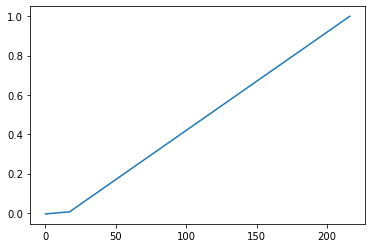

In [23]:
# ----- Addition of pre-frame --------------------------------------------

# For the successive removals of the estimated LPC envelopes, a
# mean-normalized pre-frame ramp is added at the beginning of the frame
# in order to diminish ripple. The ramp is removed after each filtering.
Lpf = nv+1                         # Pre-frame length
x_gvl = np.hstack((np.linspace(-s_gvl[0],s_gvl[0],Lpf),  s_gvl))    # Prepend
idx_pf = np.arange(Lpf, x_gvl.shape[0])     # Indexes that exclude the pre-frame

print('Lpf', Lpf)
print('x_gvl', x_gvl.shape)
print('idx_pf', idx_pf.shape, idx_pf[0], idx_pf[-1])
plt.plot(x_gvl)

In [24]:
# ----- Cancel lip radiation contribution --------------------------------
# Define lip radiation filter
al = [1.0, -d];

# Integration of signal using filter 1/[1 -d z^(-1)]
# - Input signal (for LPC estimation)
s_gv = lfilter([1.0], al, s_gvl);

# - Pre-framed input signal (for LPC envelope removal)
x_gv = lfilter([1.0], al, x_gvl);


print('s_gv', s_gv.shape)
print('x_gv', x_gv.shape)
print('win', win.shape)


s_gv (200,)
x_gv (217,)
win (200,)


In [25]:
# # ----- Gross glottis estimation -----------------------------------------
# # Iterative estimation of glottis with ng first order filters
ag1 = lb.lpc(np.multiply(s_gv, win), 1)         # First 1st order LPC estimation
print('ag1', ag1)
for i in range(ng):
    print('i', i)
    # Cancel current estimate of glottis contribution from speech signal
    x_v1x = lfilter(ag1, [1.0], x_gv)	# Inverse filtering
    s_v1x = x_v1x[idx_pf]      # Remove pre-ramp
    # Next 1st order LPC estimation
    ag1x = lb.lpc(np.multiply(s_v1x, win), 1)   # 1st order LPC
    # Update gross estimate of glottis contribution
    ag1 = np.convolve(ag1, ag1x)	# Combine 1st order estimation with previous

    print('ag1x', ag1x)
    print('ag1', ag1)

ag1 [ 1.         -0.99977308]
i 0
ag1x [ 1.         -0.99981112]
ag1 [ 1.         -1.9995842   0.99958424]
i 1
ag1x [ 1.         -0.99982158]
ag1 [ 1.         -2.99940578  2.99881167 -0.9994059 ]
i 2
ag1x [ 1.         -0.99975636]
ag1 [ 1.         -3.99916214  5.99748668 -3.99748694  0.9991624 ]


In [26]:
# ----- Fine glottis estimation ------------------------------------------
# Cancel gross estimate of vocal tract contribution from speech signal
x_g1 = lfilter(ag1, [1.0], x_gv)      # Inverse filtering
s_g1 = x_g1[idx_pf]            # Remove pre-ramp

# Fine estimate of the glottis filter
ag = lb.lpc(np.multiply(s_g1, win), ng)         # ng order estimation

In [27]:
# ----- Fine vocal tract estimation --------------------------------------
# Cancel fine estimate of glottis contribution from speech signal
x_v = lfilter(ag, [1.0], x_gv)        # Inverse filtering
s_v = x_v[idx_pf]              # Remove pre-ramp

# Fine estimate of the vocal tract filter
av = lb.lpc(np.multiply(s_v, win), nv)          # nv order LPC estimation

In [28]:
av, ag, al

(array([ 1.00000000e+00, -5.67742566e+00,  1.33603247e+01, -1.66525007e+01,
         1.15628476e+01, -4.21722459e+00,  6.19505951e-01,  4.16028924e-03,
         1.73642216e-04,  6.39553507e-05,  8.71622415e-06, -3.17808103e-03,
         1.95867928e-02, -4.64771440e-02,  5.44628758e-02, -3.16935984e-02,
         7.36528743e-03]),
 array([ 1.        ,  0.15079032, -0.09182607, -0.16945253]),
 [1.0, -0.99])